In [142]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [143]:
df = pd.read_csv('MA888.csv')

In [144]:
def reshape_data():
    result = pd.DataFrame()
    for i in range(12):
        n = i+1
        sub = pd.read_csv('month_result_data/month_'+str(n)+'_result_data.csv')
        sub = sub.loc[sub['品种/合约']=='甲醇MA']
        result = pd.concat([result, sub], axis=0)
    return result

In [145]:
df_pos = reshape_data()

In [146]:
def get_daily_postion_change(df_pos):
    adds = []
    dates = []
    minus = []
    longs = []
    shorts = []
    for date, sub in tqdm(df_pos.groupby('日期')):
        sub['增减量.1'] = sub['增减量.1'].astype('float')
        sub['增减量.2'] = sub['增减量.2'].astype('float')
        sub['持买仓量'] = sub['持买仓量'].astype('float')
        sub['持卖仓量'] = sub['持卖仓量'].astype('float')
        dates.append(date)
        adds.append(sub['增减量.1'].sum())
        minus.append(sub['增减量.2'].sum())
        longs.append(sub['持买仓量'].sum())
        shorts.append(sub['持卖仓量'].sum())
    result = pd.DataFrame({'date':dates, 'long_delta':adds, 'short_delta':minus, 'long':longs, 'short':shorts})
    return result
        

In [147]:
trading_data = df[['trading_date','close']]
trading_data = trading_data.rename(columns={'trading_date':'date'})
trading_data['date'] = pd.to_datetime(trading_data['date'])

In [148]:
df_pos_trading = get_daily_postion_change(df_pos)
df_pos_trading['date'] = pd.to_datetime(df_pos_trading['date'])

100%|██████████| 243/243 [00:00<00:00, 377.32it/s]


In [149]:
df_merge = pd.merge(trading_data, df_pos_trading, on='date')

In [169]:
def get_trading_signal(df_merge):
    df_merge['long_s'] = np.where(df_merge['long']>df_merge['long'].shift(1), 1, 0)
    df_merge['short_s'] = np.where(df_merge['short']>df_merge['short'].shift(1), 1, 0)
    df_merge['ma'] = df_merge['close'].rolling(20).mean()
    df_merge['std'] = df_merge['close'].rolling(20).std()
    df_merge['up'] = df_merge['ma']+2*df_merge['std']
    df_merge['down'] = df_merge['ma']-2*df_merge['std']
    df_merge['buy'] = np.where((df_merge['long_s']==1)&(df_merge['short_s']==1)&(df_merge['close']>df_merge['ma']),df_merge['close'],np.nan)
    df_merge['sell'] = np.where((df_merge['long_s']==0)&(df_merge['short_s']==0)&(df_merge['close']<df_merge['ma']),df_merge['close'],np.nan)
    return df_merge

In [170]:
df_merge = get_trading_signal(df_merge)

No handles with labels found to put in legend.


[]

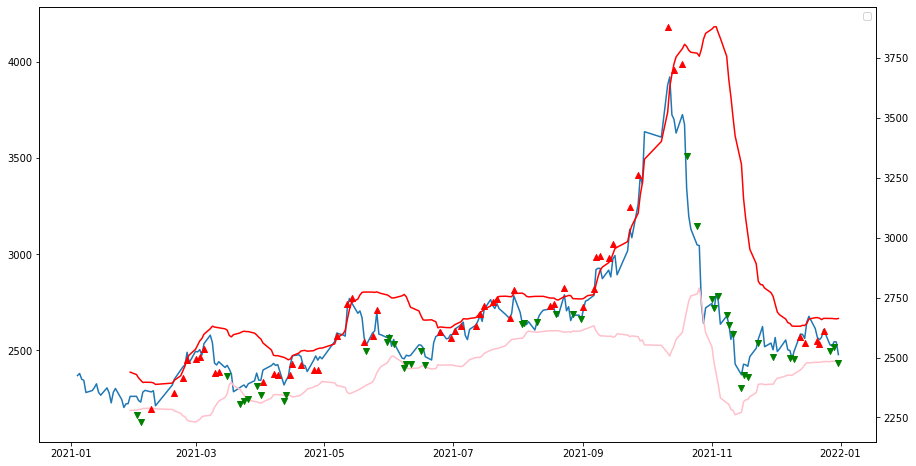

In [171]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
ax1.plot(df_merge['date'],df_merge['close'])
ax1.plot(df_merge['date'],df_merge['up'],color='red')
ax1.plot(df_merge['date'],df_merge['down'],color='pink')

ax2 = ax1.twinx()
ax2.scatter(df_merge['date'],df_merge['buy'],marker='^',color='red')
ax2.scatter(df_merge['date'],df_merge['sell'],marker='v',color='green')
plt.legend()
plt.plot()

In [172]:
buys = []
sells = []
ret = []
flag = 0
# df_merge = df_merge.dropna()
for i in range(0,len(df_merge)):
    close = df_merge['close'].iat[i]
    buy = df_merge['buy'].iat[i]
    sell = df_merge['sell'].iat[i]
    if flag==0:
        if buy>0:
            buys.append(close)
            flag=1
        else:
            flag=flag
    else:
        if sell>0:
            sells.append(close)
            flag=0
            ret.append(close/buys[-1]-1)
        else:
            flag=flag
            
           
            

In [177]:
df_ret = pd.DataFrame({'ret':ret})
cumret = ((df_ret+1).cumprod()-1).iloc[-1][0]
print('Cumulative return: ',cumret)
print('The max gain: ',np.max(ret))
print('The max loss: ',np.min(ret))
print('Trading number: ',len(ret))
print('Average return: ',np.mean(ret))

Cumulative return:  0.22818156186370797
The max gain:  0.23266961651917395
The max loss:  -0.03800645392613844
Trading number:  9
Average return:  0.025926425644773075
